<a href="https://colab.research.google.com/github/Tanainan/Covid-19Thailand/blob/main/Covid_python_ML_univariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
!pip install -U tensorflow-addons
from numpy import hstack
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
import numpy as np
from statistics import stdev
from statistics import mean
from matplotlib import pyplot
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
from matplotlib import pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
import plotly.graph_objects as go
from statsmodels.graphics.factorplots import interaction_plot
np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
import itertools
!pip install -U scikit-learn
from sklearn.metrics import mean_absolute_percentage_error
from tensorflow.keras.utils import to_categorical
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from warnings import simplefilter
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

     |████████████████████████████████| 1.1 MB 7.1 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


### Data

In [91]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_cases.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Cases_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Cases_daily"]] = data[["Cases_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# reset index
data_i = data.reset_index(drop = True)


In [92]:
data = read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/jhu/new_deaths.csv")

data = pd.DataFrame(data)

# select columns
data = data[["date", "Thailand"]]

# change column name
data = data.rename(columns = {'date':'Date', 'Thailand':'Deaths_daily'})

# # change date format
data.Date =  pd.to_datetime(data["Date"])

# replace NaN with 0 for ConfirmedCases and ConfirmedDeaths
data[["Deaths_daily"]] = data[["Deaths_daily"]].replace(np.nan, 0)

# start from 15/6/2021
data = data[data.loc[data['Date'] == "2021-06-15"].index[0]:]

# reset index
data_d = data.reset_index(drop = True)


In [93]:
window = 3 # for moving average
days_predicted = 14
lag = 14
index = 30

# moving average
data_i['Cases_daily2'] = data_i.Cases_daily
data_i['Cases_daily'] = data_i.Cases_daily.rolling(window).mean()

data_d['Deaths_daily2'] = data_d.Deaths_daily
data_d['Deaths_daily'] = data_d.Deaths_daily.rolling(window).mean()


# remove NaN
data_i.dropna(subset = ["Cases_daily"], inplace=True)
data_d.dropna(subset = ["Deaths_daily"], inplace=True)

data_i = data_i.reset_index(drop = True)
data_d = data_d.reset_index(drop = True)



# Linear Regression

## Cases

MAPE = 0.17047969676465888


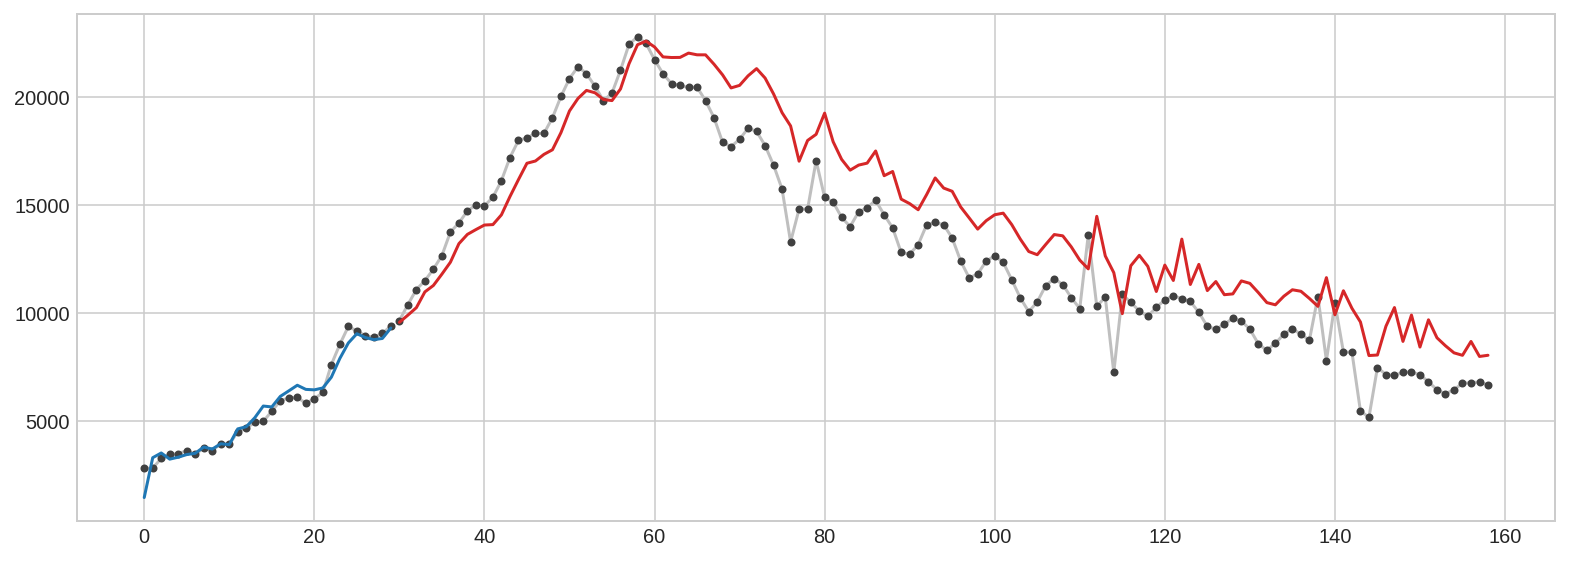

In [109]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X_i = make_lags(data_i.Cases_daily, lags=lag)
X_i = X_i.fillna(0.0)

# Create target series and data splits
y_i = data_i.Cases_daily.copy()
X_i_train, X_i_test, y_i_train, y_i_test = train_test_split(X_i, y_i, train_size=index, shuffle=False)

X_i_test = X_i_test.iloc[:-14,:]
y_i_test = y_i_test.iloc[:-14]

model_lr_i = LinearRegression() 
model_lr_i.fit(X_i_train, y_i_train)
y_pred_lr_i = pd.Series(model_lr_i.predict(X_i_train), index=y_i_train.index)
y_fore_lr_i = pd.Series(model_lr_i.predict(X_i_test), index=y_i_test.index)
y_total_lr_i = pd.concat([y_pred_lr_i, y_fore_lr_i])

mape_lr_i = mean_absolute_percentage_error(y_i_test, y_fore_lr_i)

print("MAPE =", mape_lr_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_lr_i.plot(ax=ax)
_ = y_fore_lr_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.20915809105900898


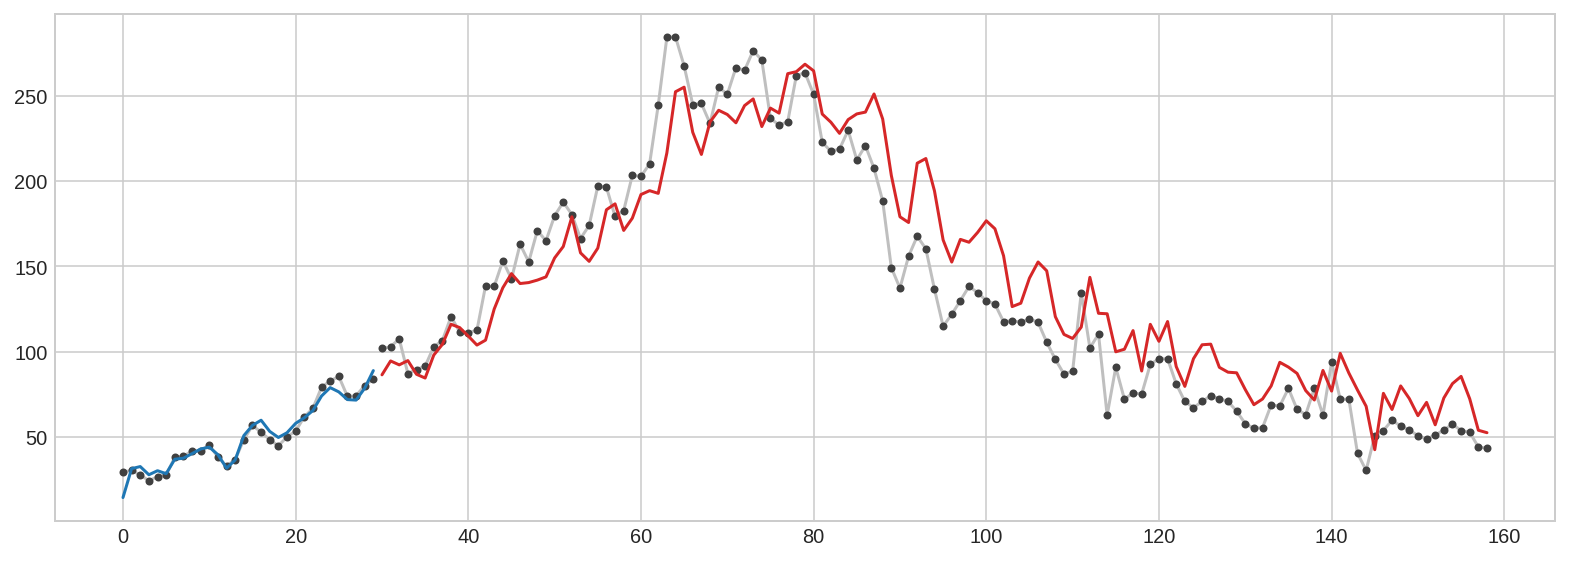

In [110]:
X_d = make_lags(data_d.Deaths_daily, lags=lag)
X_d = X_d.fillna(0.0)

# Create target series and data splits
y_d = data_d.Deaths_daily.copy()
X_d_train, X_d_test, y_d_train, y_d_test = train_test_split(X_d, y_d, train_size=index, shuffle=False)

X_d_test = X_d_test.iloc[:-14,:]
y_d_test = y_d_test.iloc[:-14]

model_lr_d = LinearRegression() 
model_lr_d.fit(X_d_train, y_d_train)
y_pred_lr_d = pd.Series(model_lr_d.predict(X_d_train), index=y_d_train.index)
y_fore_lr_d = pd.Series(model_lr_d.predict(X_d_test), index=y_d_test.index)
y_total_lr_d = pd.concat([y_pred_lr_d, y_fore_lr_d])

mape_lr_d = mean_absolute_percentage_error(y_d_test, y_fore_lr_d)

print("MAPE =", mape_lr_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_lr_d.plot(ax=ax)
_ = y_fore_lr_d.plot(ax=ax, color='C3')

# Ridge Regression

## Cases

MAPE = 0.1704797055170746


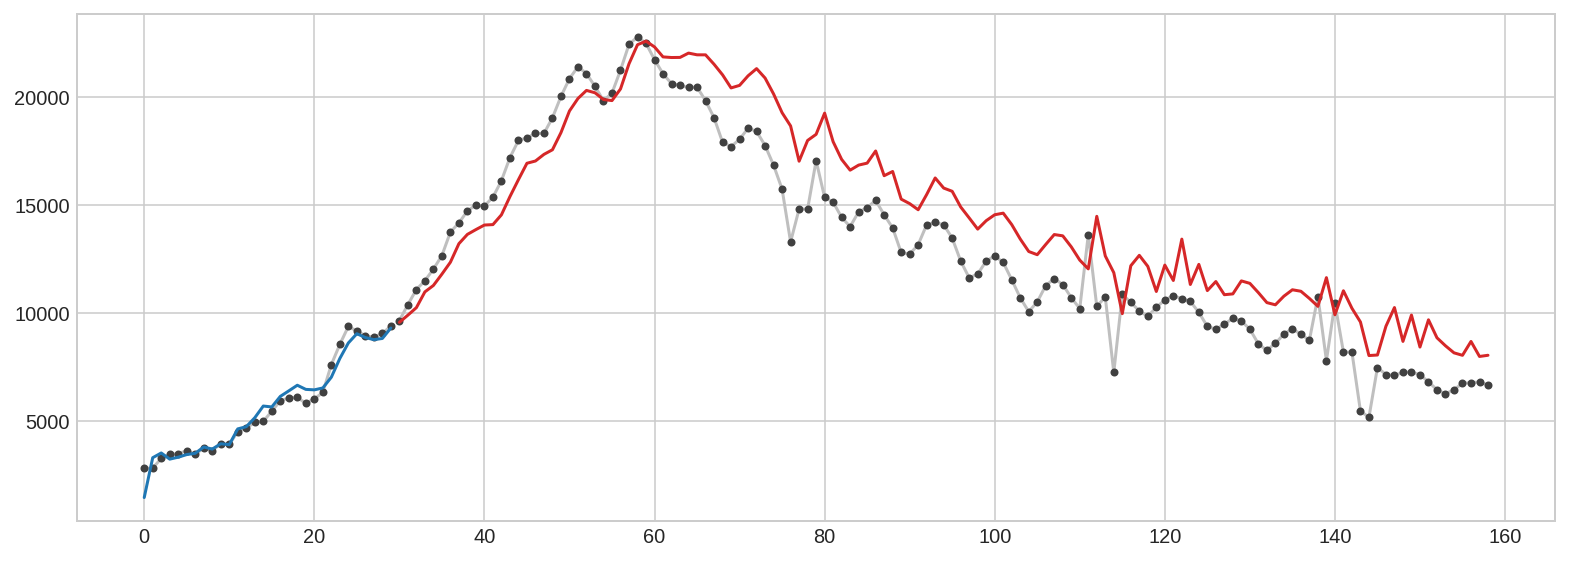

In [111]:
model_rr_i = Ridge() 
model_rr_i.fit(X_i_train, y_i_train)
y_pred_rr_i = pd.Series(model_rr_i.predict(X_i_train), index=y_i_train.index)
y_fore_rr_i = pd.Series(model_rr_i.predict(X_i_test), index=y_i_test.index)
y_total_rr_i = pd.concat([y_pred_rr_i, y_fore_rr_i])

mape_rr_i = mean_absolute_percentage_error(y_i_test, y_fore_rr_i)

print("MAPE =", mape_rr_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_rr_i.plot(ax=ax)
_ = y_fore_rr_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.20922543955380613


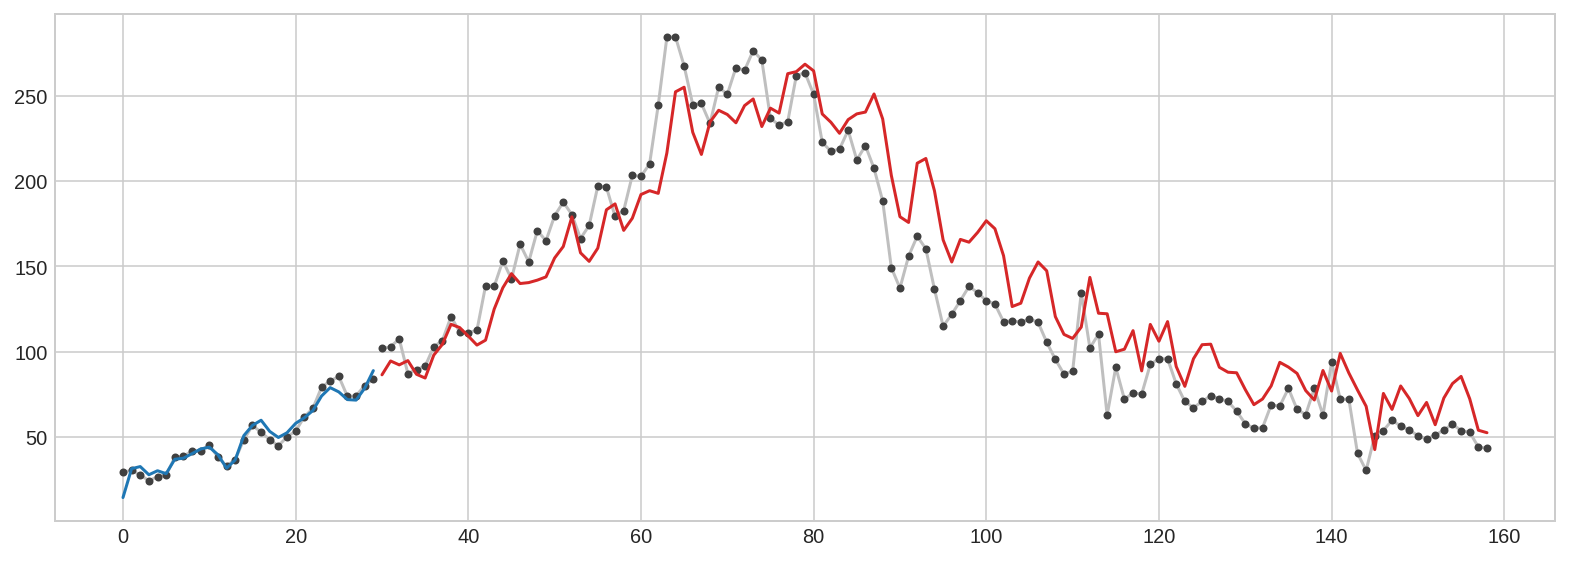

In [112]:

model_rr_d = Ridge()
model_rr_d.fit(X_d_train, y_d_train)
y_pred_rr_d = pd.Series(model_rr_d.predict(X_d_train), index=y_d_train.index)
y_fore_rr_d = pd.Series(model_rr_d.predict(X_d_test), index=y_d_test.index)
y_total_rr_d = pd.concat([y_pred_rr_d, y_fore_rr_d])

mape_rr_d = mean_absolute_percentage_error(y_d_test, y_fore_rr_d)

print("MAPE =", mape_rr_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_rr_d.plot(ax=ax)
_ = y_fore_rr_d.plot(ax=ax, color='C3')

# Lasso Regression

## Cases

MAPE = 0.17047970814016272


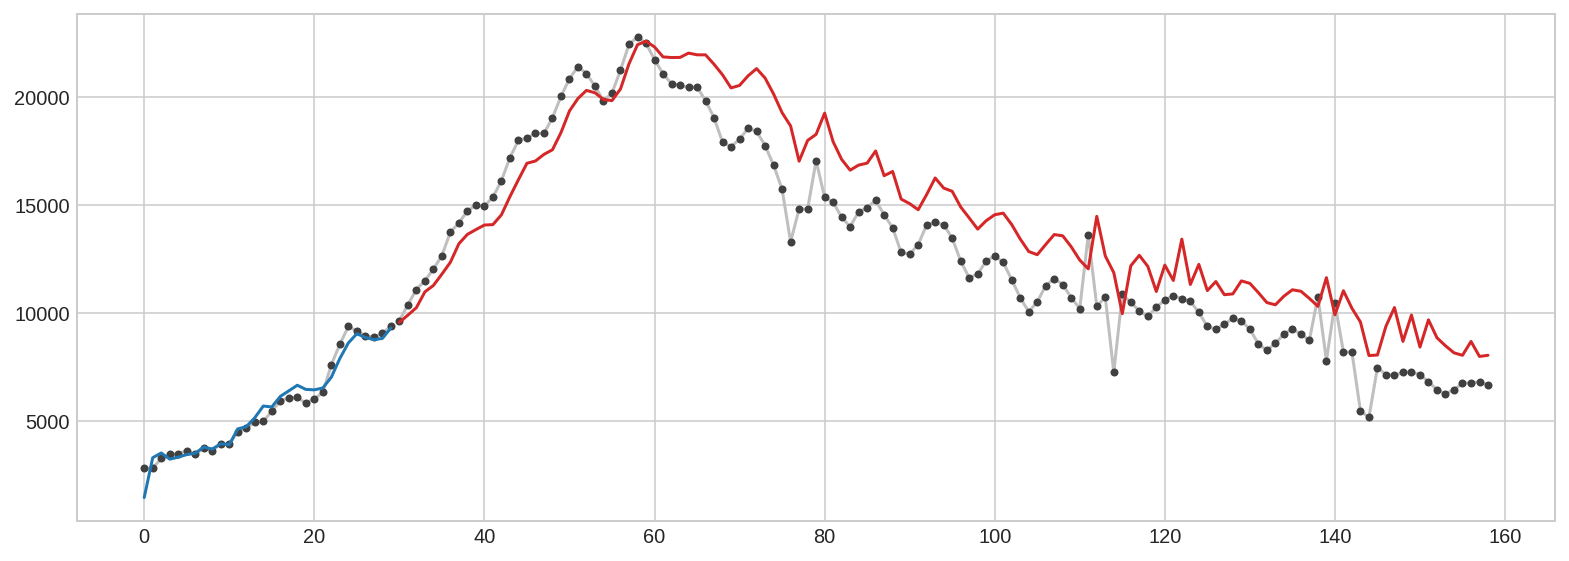

In [113]:
model_ls_i = Lasso(alpha = 0.1) 
model_ls_i.fit(X_i_train, y_i_train)
y_pred_ls_i = pd.Series(model_ls_i.predict(X_i_train), index=y_i_train.index)
y_fore_ls_i = pd.Series(model_ls_i.predict(X_i_test), index=y_i_test.index)
y_total_ls_i = pd.concat([y_pred_ls_i, y_fore_ls_i])

mape_ls_i = mean_absolute_percentage_error(y_i_test, y_fore_ls_i)

print("MAPE =", mape_ls_i)

ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_ls_i.plot(ax=ax)
_ = y_fore_ls_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.20930578437276953


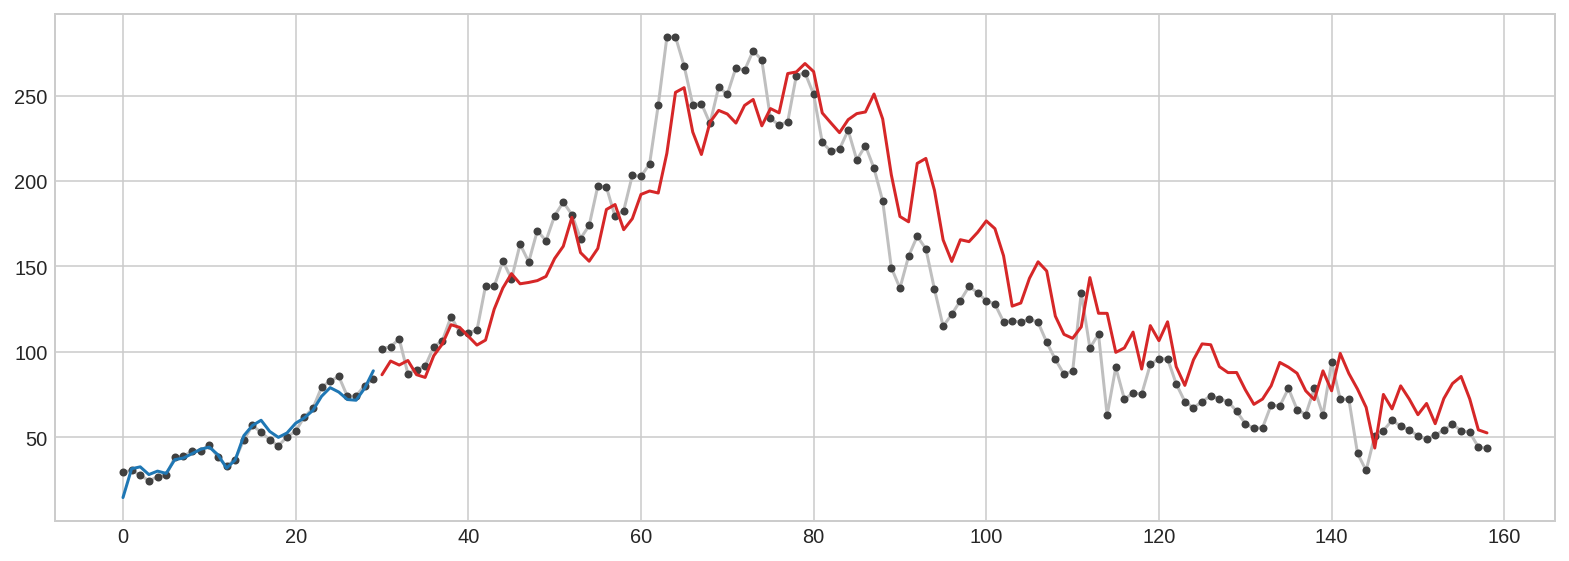

In [114]:

model_ls_d = Lasso(alpha = 0.1)
model_ls_d.fit(X_d_train, y_d_train)
y_pred_ls_d = pd.Series(model_ls_d.predict(X_d_train), index=y_d_train.index)
y_fore_ls_d = pd.Series(model_ls_d.predict(X_d_test), index=y_d_test.index)
y_total_ls_d = pd.concat([y_pred_ls_d, y_fore_ls_d])

mape_ls_d = mean_absolute_percentage_error(y_d_test, y_fore_ls_d)

print("MAPE =", mape_ls_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_ls_d.plot(ax=ax)
_ = y_fore_ls_d.plot(ax=ax, color='C3')

# XGBoost

## Cases

MAPE = 0.3031744113520709


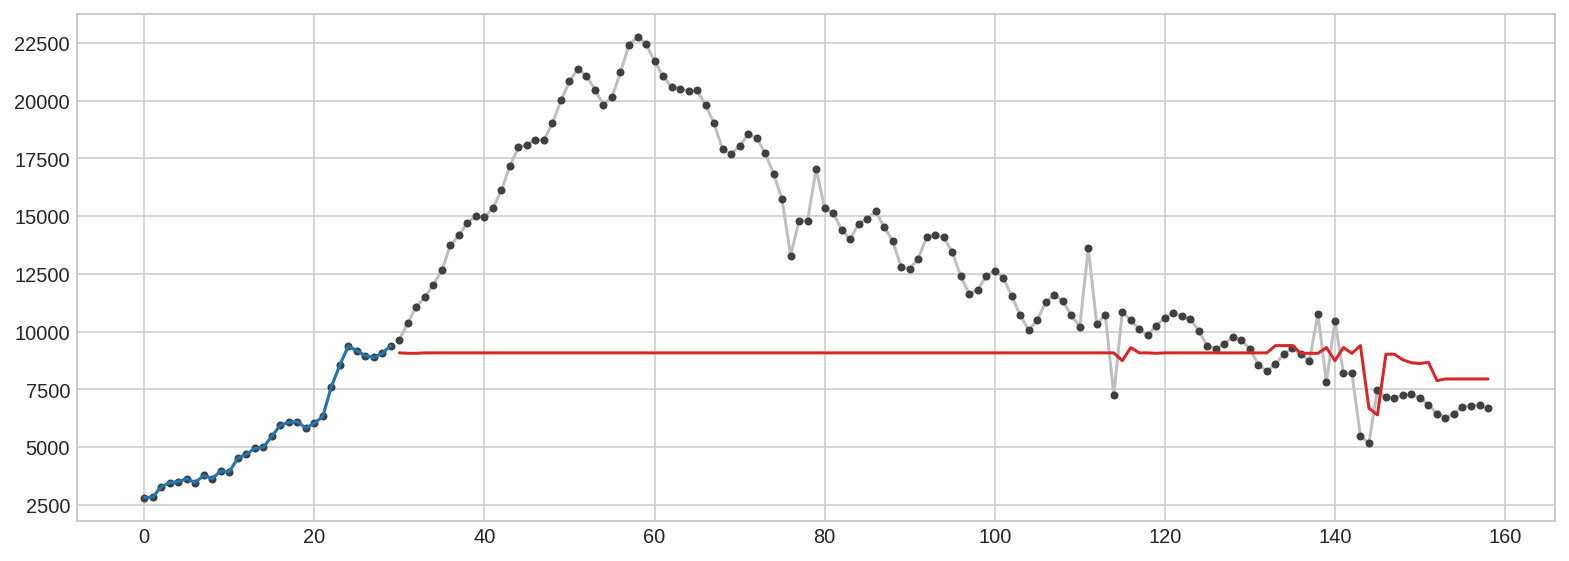

In [115]:
model_xg_i = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xg_i.fit(X_i_train, y_i_train)
y_pred_xg_i = pd.Series(model_xg_i.predict(X_i_train), index=y_i_train.index)
y_fore_xg_i = pd.Series(model_xg_i.predict(X_i_test), index=y_i_test.index)
y_total_xg_i = pd.concat([y_pred_xg_i, y_fore_xg_i])

mape_xg_i = mean_absolute_percentage_error(y_i_test, y_fore_xg_i)


print("MAPE =", mape_xg_i)


ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_xg_i.plot(ax=ax)
_ = y_fore_xg_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.4018385943965581


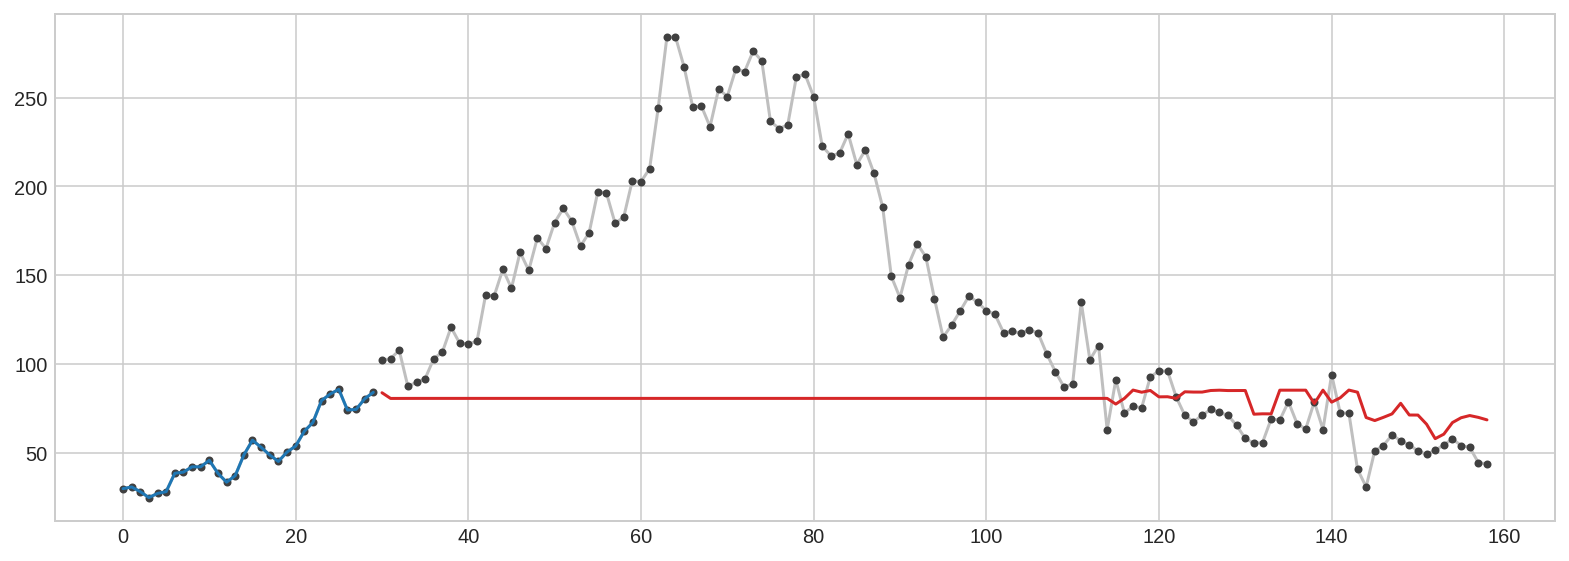

In [116]:
model_xg_d = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model_xg_d.fit(X_d_train, y_d_train)
y_pred_xg_d = pd.Series(model_xg_d.predict(X_d_train), index=y_d_train.index)
y_fore_xg_d = pd.Series(model_xg_d.predict(X_d_test), index=y_d_test.index)
y_total_xg_d = pd.concat([y_pred_xg_d, y_fore_xg_d])


mape_xg_d = mean_absolute_percentage_error(y_d_test, y_fore_xg_d)

print("MAPE =", mape_xg_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_xg_d.plot(ax=ax)
_ = y_fore_xg_d.plot(ax=ax, color='C3')

# Elastic Net

## Cases

MAPE = 0.17047979975838973


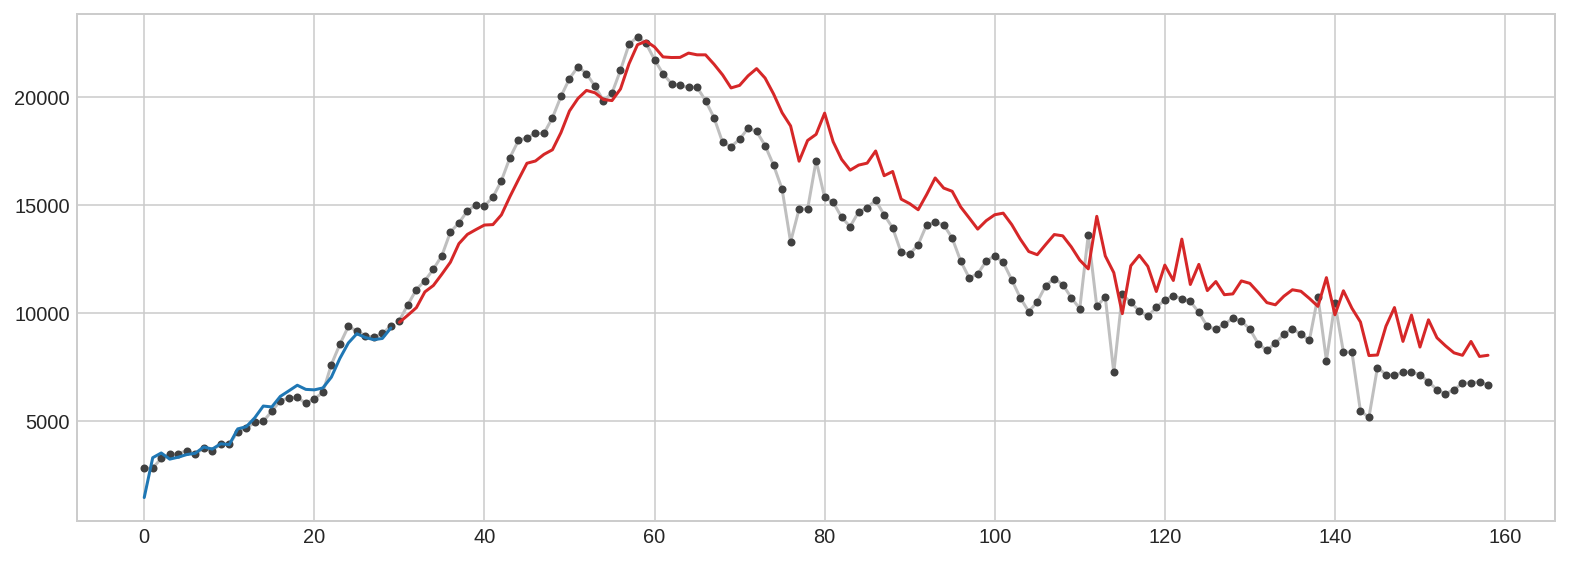

In [117]:
model_en_i = ElasticNet(alpha=0.5)
model_en_i.fit(X_i_train, y_i_train)
y_pred_en_i = pd.Series(model_en_i.predict(X_i_train), index=y_i_train.index)
y_fore_en_i = pd.Series(model_en_i.predict(X_i_test), index=y_i_test.index)
y_total_en_i = pd.concat([y_pred_en_i, y_fore_en_i])

mape_en_i = mean_absolute_percentage_error(y_i_test, y_fore_en_i)


print("MAPE =", mape_en_i)


ax = y_i_train.plot(**plot_params)
ax = y_i_test.plot(**plot_params)
ax = y_pred_en_i.plot(ax=ax)
_ = y_fore_en_i.plot(ax=ax, color='C3')

## Deaths

MAPE = 0.21005791338587967


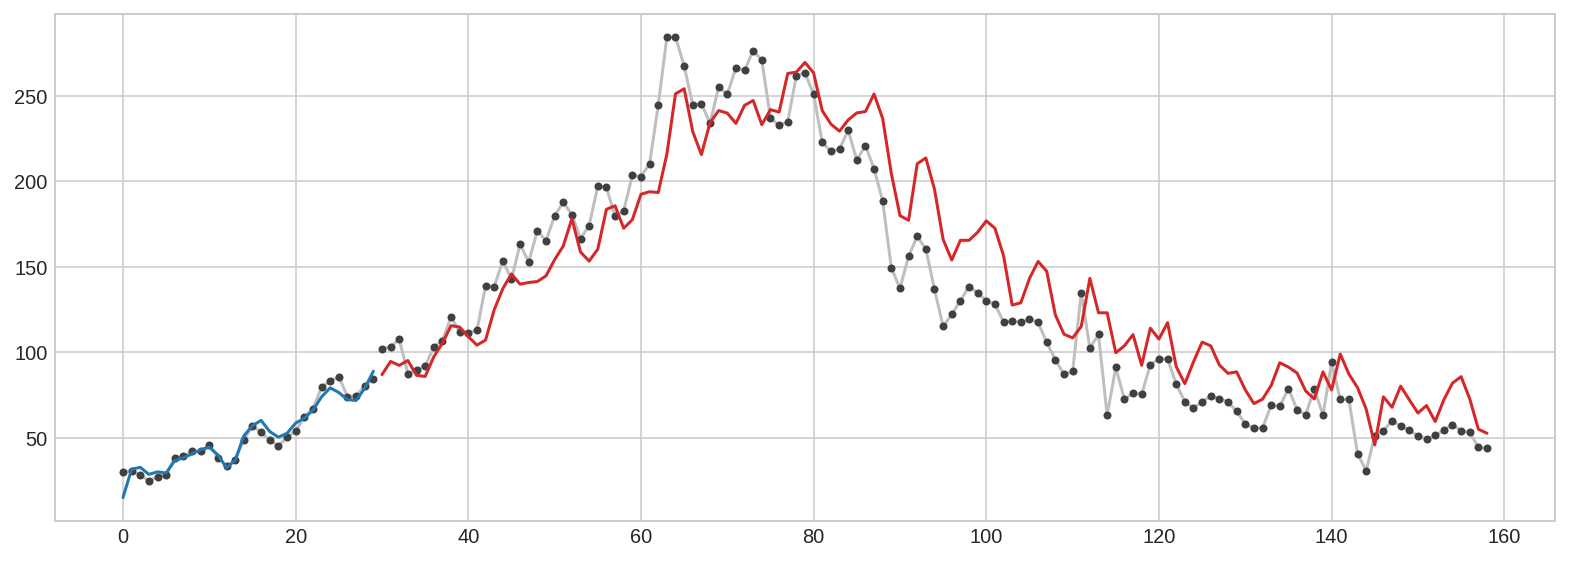

In [118]:
model_en_d = ElasticNet(alpha = 0.5)
model_en_d.fit(X_d_train, y_d_train)
y_pred_en_d = pd.Series(model_en_d.predict(X_d_train), index=y_d_train.index)
y_fore_en_d = pd.Series(model_en_d.predict(X_d_test), index=y_d_test.index)
y_total_en_d = pd.concat([y_pred_en_d, y_fore_en_d])

mape_en_d = mean_absolute_percentage_error(y_d_test, y_fore_en_d)

print("MAPE =", mape_en_d)


ax = y_d_train.plot(**plot_params)
ax = y_d_test.plot(**plot_params)
ax = y_pred_en_d.plot(ax=ax)
_ = y_fore_en_d.plot(ax=ax, color='C3')

# Result Table

## Cases

In [119]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Test MAPE'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Linear Regression', 
                                                   'Ridge Regression',
                                                   'Lasso Regression',
                                                   'Elastic Net',
                                                   'XGBoost'],
                                                  [round(mape_lr_i,4), round(mape_rr_i,4), round(mape_lr_i,4), round(mape_en_i,4), round(mape_xg_i,4)]],
                            align=['left','center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error: Confirmed Cases",title_x=0.5)
fig.show()

## Deaths

In [120]:
fig = go.Figure(data=[go.Table(header=dict(values=['Model', 'Test MAPE'],
                                           line_color = 'gray'),
                               cells=dict(values=[['Linear Regression', 
                                                   'Ridge Regression',
                                                   'Lasso Regression',
                                                   'Elastic Net',
                                                   'XGBoost'],
                                                  [round(mape_lr_d,4), round(mape_rr_d,4), round(mape_lr_d,4), round(mape_en_d,4), round(mape_xg_d,4)]],
                            align=['left','center', 'center'],
                            fill_color = 'white',
                            line_color = 'gray'))
                     ])
fig.update_layout(title = "Mean Absolute Percentage Error: Confirmed Deaths",title_x=0.5)
fig.show()

# Future Predictions

---

In univariate, we used predicted values as new input for future predictions. Since we predicted 14 days ahead, each of the day required 14 previous days as input. For example, the 2nd predicted day would use actual data of previous 13 days and 1 predicted data from the 1st predicted day. We used the same RNNs and LSTM models for confirmed cases and confirmed deaths future predictions, respectively.

In [121]:
# Univariate
def future_prediction_uni(input, model, days_predicted, total_prediction):
  all_prediction = pd.DataFrame(total_prediction)

  # use the last 14 days from actual data
  all_input = input

  for i in range(1,days_predicted + 1):
    # create a matrix of input with 14 previous days
    new_input = all_input[-14:].values
    new_input = new_input.reshape(1,14)

    # set seed
    seed(1)
    tensorflow.random.set_seed(1)

    # make the next day prediction
    last_output = model.predict(new_input)

    all_prediction = pd.concat([all_prediction, pd.DataFrame(last_output)], ignore_index=True)

    # feed the output back as new input
    all_input = pd.concat([all_input, pd.DataFrame(last_output)], ignore_index=True)
    all_input = pd.DataFrame(all_input)
  return all_prediction


In [122]:

# linear regression confirmed cases
uni_i_pred_lr = future_prediction_uni(data_i.Cases_daily, model_lr_i, days_predicted, y_total_lr_i)

# linear regression confirmed deaths
uni_d_pred_lr = future_prediction_uni(data_d.Deaths_daily, model_lr_d, days_predicted, y_total_lr_d)

# ridge confirmed cases
uni_i_pred_rr = future_prediction_uni(data_i.Cases_daily, model_rr_i, days_predicted, y_total_rr_i)

# ridge confirmed deaths
uni_d_pred_rr = future_prediction_uni(data_d.Deaths_daily, model_rr_d, days_predicted, y_total_rr_d)

# lasso confirmed cases
uni_i_pred_ls = future_prediction_uni(data_i.Cases_daily, model_ls_i, days_predicted, y_total_ls_i)

# lasso confirmed deaths
uni_d_pred_ls = future_prediction_uni(data_d.Deaths_daily, model_ls_d, days_predicted, y_total_ls_d)

# xgboost confirmed cases
# uni_i_pred_xg = future_prediction_uni(data_i.Cases_daily, model_xg_i, days_predicted, y_total_xg_i)

# xgboost confirmed deaths
# uni_d_pred_xg = future_prediction_uni(data_d.Deaths_daily, model_xg_d, days_predicted, y_total_xg_d)

# elastic net confirmed cases
uni_i_pred_en = future_prediction_uni(data_i.Cases_daily, model_en_i, days_predicted, y_total_en_i)

# elastic net confirmed deaths
uni_d_pred_en = future_prediction_uni(data_d.Deaths_daily, model_en_d, days_predicted, y_total_en_d)



### Plots

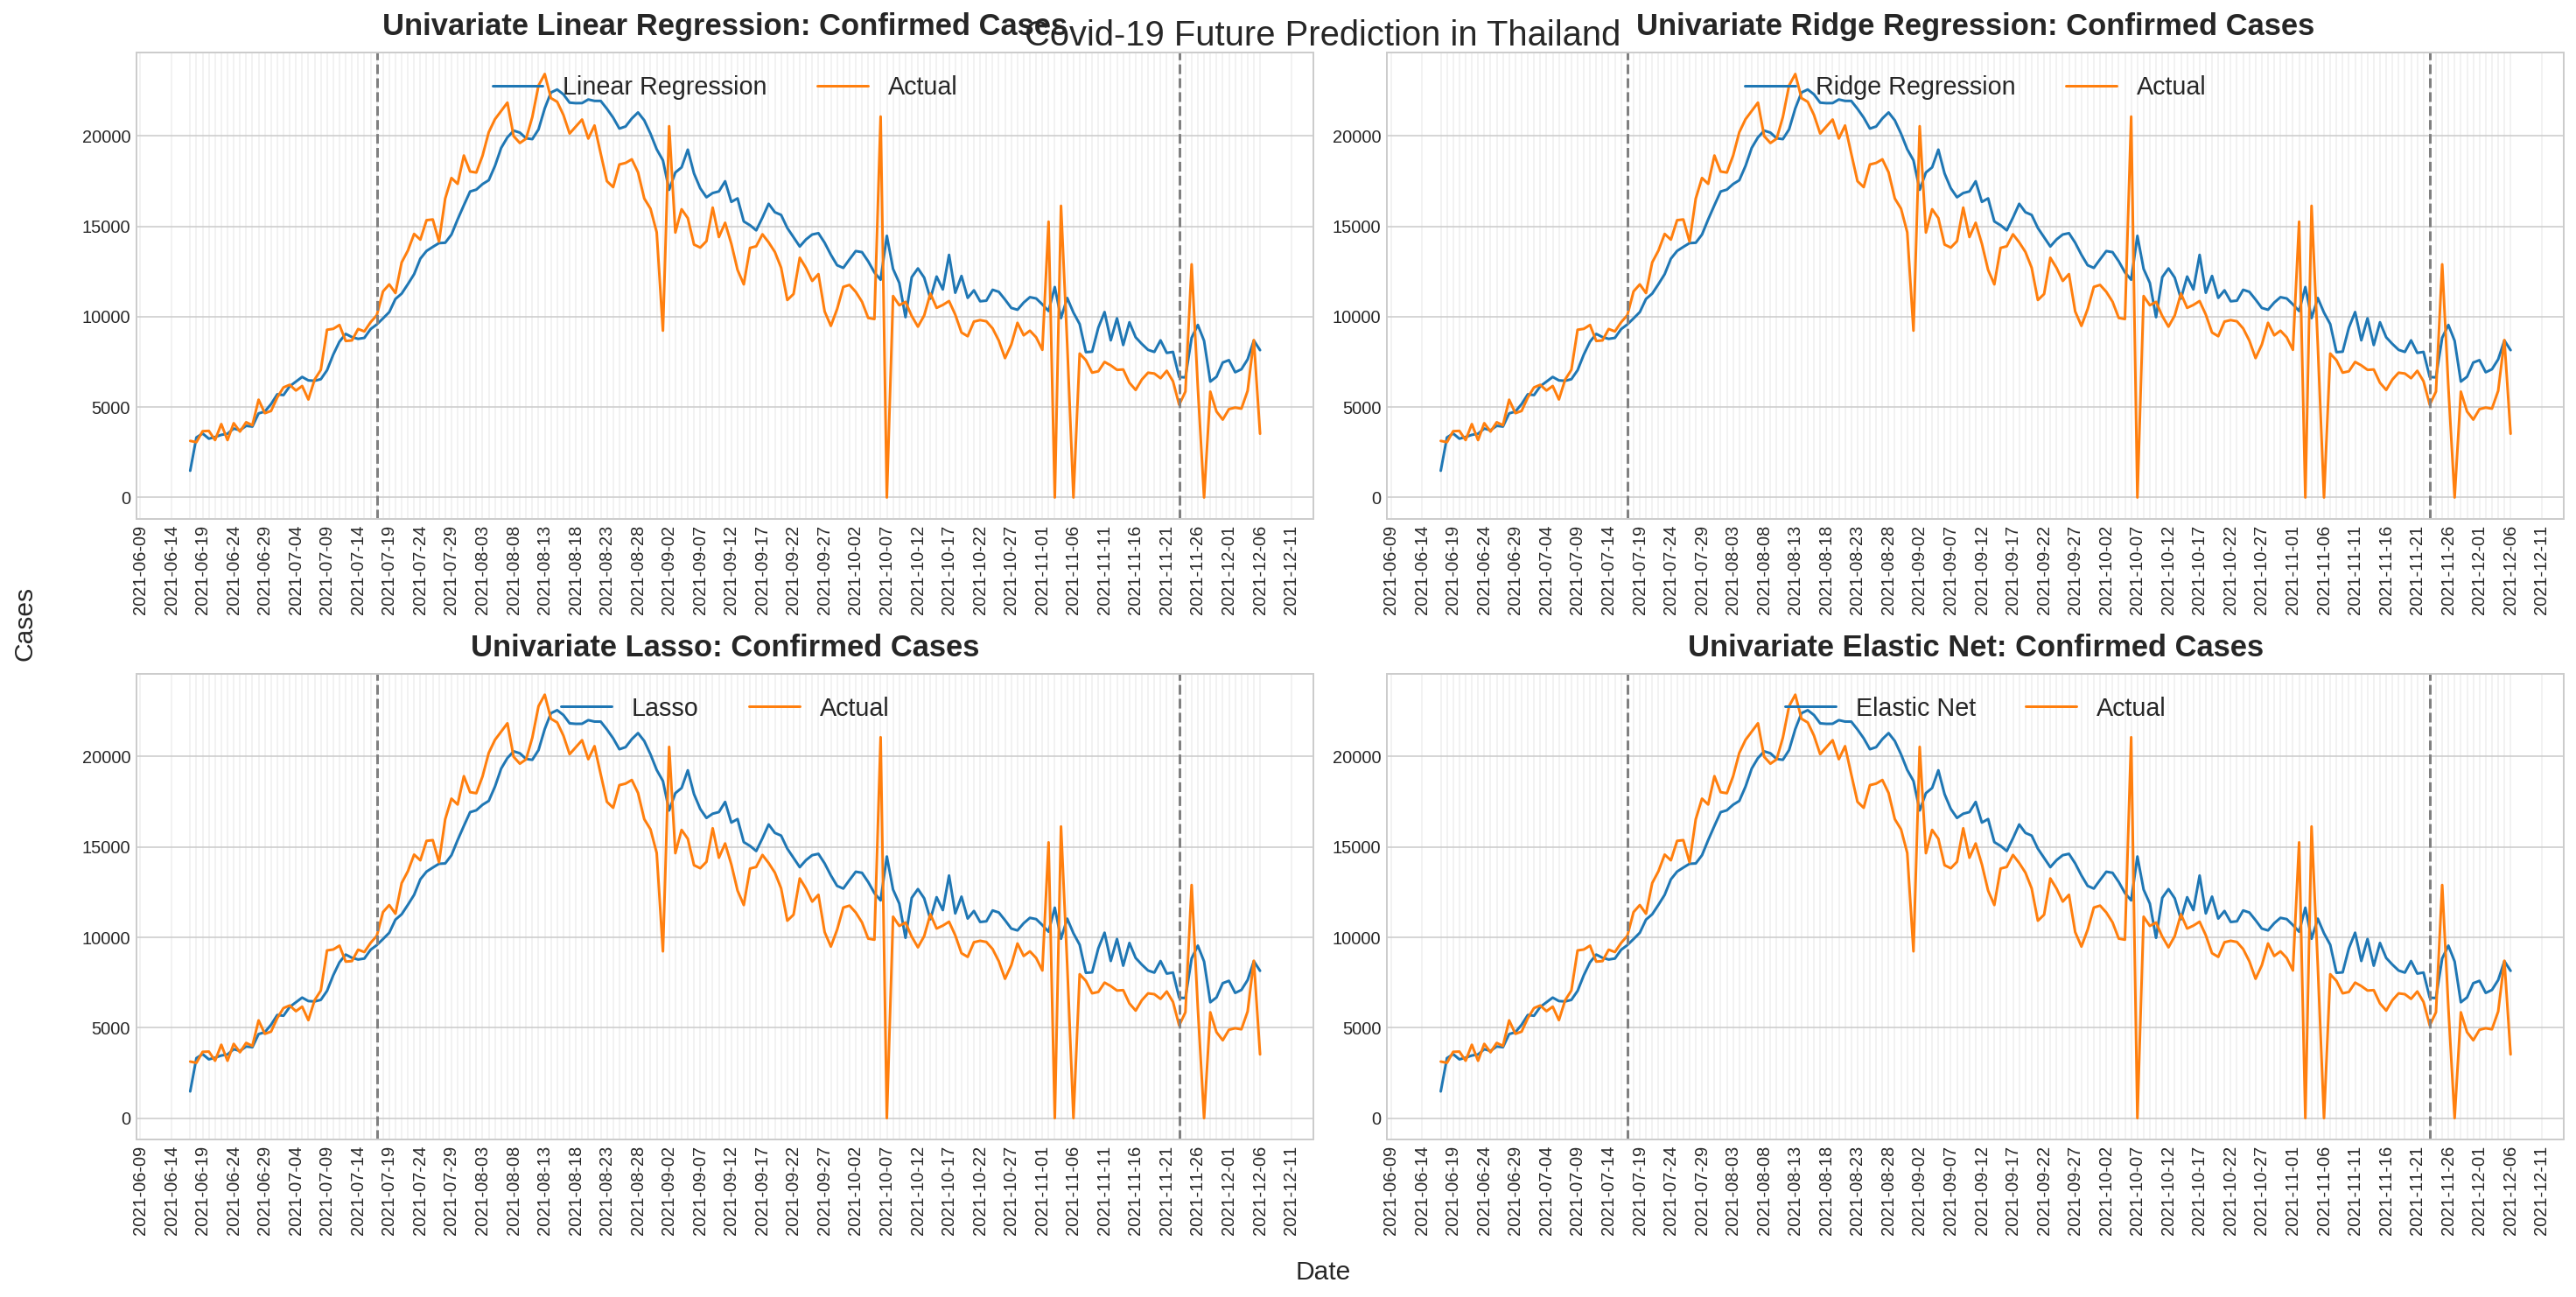

In [130]:

pred = pd.concat([uni_i_pred_lr, 
                  uni_d_pred_lr,
                  uni_i_pred_rr, 
                  uni_d_pred_rr,
                  uni_i_pred_ls, 
                  uni_d_pred_ls,
                  uni_i_pred_en, 
                  uni_d_pred_en],
                 axis=1)

pred.columns= ['uni_i_pred_lr', 
                  'uni_d_pred_lr',
                  'uni_i_pred_rr', 
                  'uni_d_pred_rr',
                  'uni_i_pred_ls', 
                  'uni_d_pred_ls',
                  'uni_i_pred_en', 
                  'uni_d_pred_en']

start_date = data.Date.iloc[0+window - 1]

# extract actual data
act_i = data_i[(data_i['Date'] >= start_date)].reset_index(drop = True)
act_i = act_i[0:len(pred)]

act_d = data_d[(data_d['Date'] >= start_date)].reset_index(drop = True)
act_d = act_d[0:len(pred)]

pred = pd.concat([pred, act_i.Cases_daily2, act_d.Deaths_daily2, act_i.Date], axis = 1)

date_test = pred['Date'][0+index]
date_predict = pred['Date'][len(y_total_lr_i)]
tick_spacing = 5

fig, axes = plt.subplots(2, 2, figsize=(20,10)) 
fig.suptitle("Covid-19 Future Prediction in Thailand", fontsize=20)

axes[0,0].plot(pred['Date'],pred['uni_i_pred_lr'], label = "Linear Regression")
axes[0,0].plot(pred['Date'], pred['Cases_daily2'], label = "Actual")
axes[0,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,0].set_title("Univariate Linear Regression: Confirmed Cases", fontsize = 'xx-large')
axes[0,0].tick_params('x',labelrotation=90)
axes[0,0].axvline(date_test, color="gray", linestyle="--")
axes[0,0].axvline(date_predict, color="gray", linestyle="--")
axes[0,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,0].set_xticks(pred['Date'], minor=True)
axes[0,0].xaxis.grid(True, which='both', alpha=0.3)

# ridge
axes[0,1].plot(pred['Date'], pred['uni_i_pred_rr'], label = "Ridge Regression")
axes[0,1].plot(pred['Date'], pred['Cases_daily2'], label = "Actual")
axes[0,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[0,1].set_title("Univariate Ridge Regression: Confirmed Cases", fontsize = 'xx-large')
axes[0,1].tick_params('x',labelrotation=90)
axes[0,1].axvline(date_test, color="gray", linestyle="--")
axes[0,1].axvline(date_predict, color="gray", linestyle="--")
axes[0,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[0,1].set_xticks(pred['Date'], minor=True)
axes[0,1].xaxis.grid(True, which='both', alpha=0.3)

# lasso
axes[1,0].plot(pred['Date'], pred['uni_i_pred_ls'], label = "Lasso")
axes[1,0].plot(pred['Date'], pred['Cases_daily2'], label = "Actual")
axes[1,0].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,0].set_title("Univariate Lasso: Confirmed Cases", fontsize = 'xx-large')
axes[1,0].tick_params('x',labelrotation=90)
axes[1,0].axvline(date_test, color="gray", linestyle="--")
axes[1,0].axvline(date_predict, color="gray", linestyle="--")
axes[1,0].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,0].set_xticks(pred['Date'], minor=True)
axes[1,0].xaxis.grid(True, which='both', alpha=0.3)

# elastic net
axes[1,1].plot(pred['Date'], pred['uni_i_pred_en'], label = "Elastic Net")
axes[1,1].plot(pred['Date'], pred['Cases_daily2'], label = "Actual")
axes[1,1].legend(frameon=False, loc='upper center', ncol = 2, fontsize = 'x-large')
axes[1,1].set_title("Univariate Elastic Net: Confirmed Cases", fontsize = 'xx-large')
axes[1,1].tick_params('x',labelrotation=90)
axes[1,1].axvline(date_test, color="gray", linestyle="--")
axes[1,1].axvline(date_predict, color="gray", linestyle="--")
axes[1,1].xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axes[1,1].set_xticks(pred['Date'], minor=True)
axes[1,1].xaxis.grid(True, which='both', alpha=0.3)

fig.text(0.5, -0.02, 'Date', ha='center', fontsize=15)
fig.text(-0.02, 0.5, 'Cases', va='center', rotation='vertical', fontsize=15)
fig.tight_layout(pad=3.0)
fig.subplots_adjust(top=0.9)
plt.show()